In [1]:
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


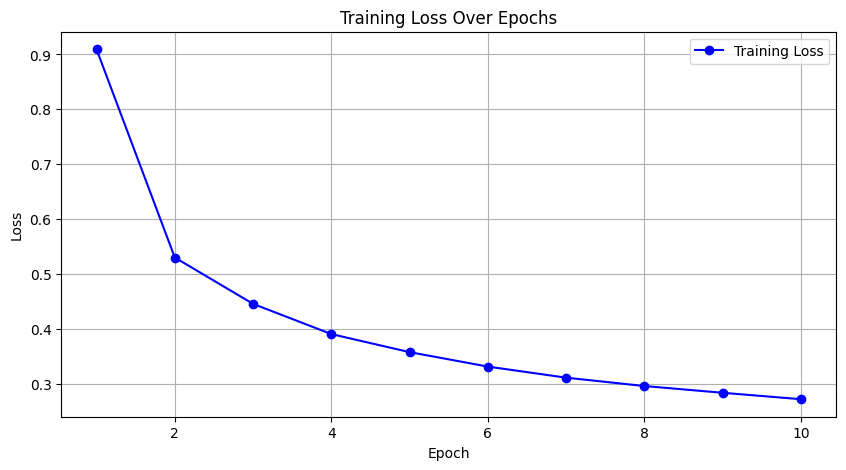

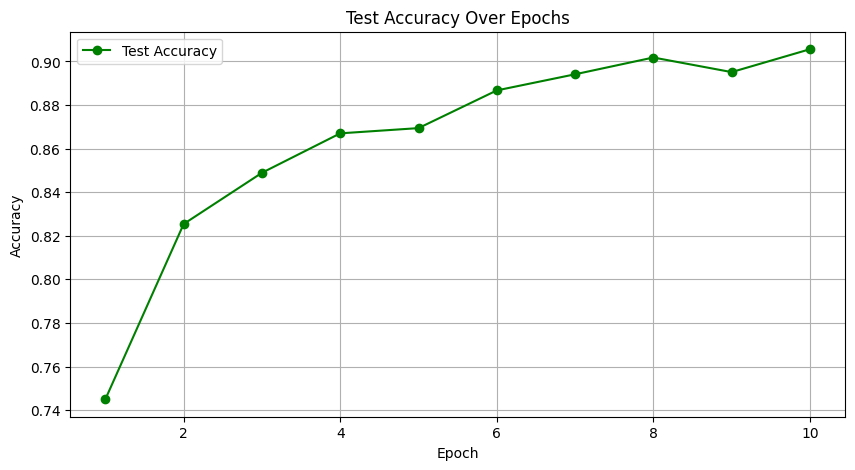

In [2]:
import matplotlib.pyplot as plt

# Data from the training logs
epochs = list(range(1, 11))
train_losses = [0.9095, 0.5303, 0.4459, 0.3909, 0.3580, 0.3317, 0.3115, 0.2963, 0.2840, 0.2723]
test_accuracies = [0.7450, 0.8254, 0.8489, 0.8670, 0.8694, 0.8867, 0.8941, 0.9018, 0.8951, 0.9056]

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, marker='o', label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_accuracies, marker='o', label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.grid(True)
plt.legend()
plt.show()



In [11]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torch.nn as nn
from torchdiffeq import odeint


# ODEBlock과 Flatten은 학습 코드에서 정의했던 것과 동일하게 다시 정의해야 합니다
class ODEfunc(nn.Module):
    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = nn.GroupNorm(min(32, dim), dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(dim, dim, 3, 1, 1)
        self.norm2 = nn.GroupNorm(min(32, dim), dim)
        self.conv2 = nn.Conv2d(dim, dim, 3, 1, 1)

    def forward(self, t, x):
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(out)
        return out

class ODEBlock(nn.Module):
    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=1e-3, atol=1e-3)
        return out[1]

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


In [12]:
def get_test_loader(batch_size=16):
    transform_test = transforms.Compose([transforms.ToTensor()])
    test_loader = DataLoader(
        FashionMNIST(root='.data/fashion-mnist', train=False, download=True, transform=transform_test),
        batch_size=batch_size, shuffle=False
    )
    return test_loader

test_loader = get_test_loader()


In [13]:
# 모델 정의
downsampling_layers = [
    nn.Conv2d(1, 64, 3, 1),
    nn.GroupNorm(32, 64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, 4, 2, 1),
    nn.GroupNorm(32, 64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, 4, 2, 1),
]
feature_layers = [ODEBlock(ODEfunc(64))]
fc_layers = [
    nn.GroupNorm(32, 64),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1, 1)),
    Flatten(),
    nn.Linear(64, 10),
]
model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers)

# 가중치 로드
model.load_state_dict(torch.load("fashion_mnist_model.pth"))
model.eval()
print("Model loaded successfully.")


Model loaded successfully.


C:\Users\surye\AppData\Local\Temp\ipykernel_23408\310430632.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fashion_mnist_model.pth"))

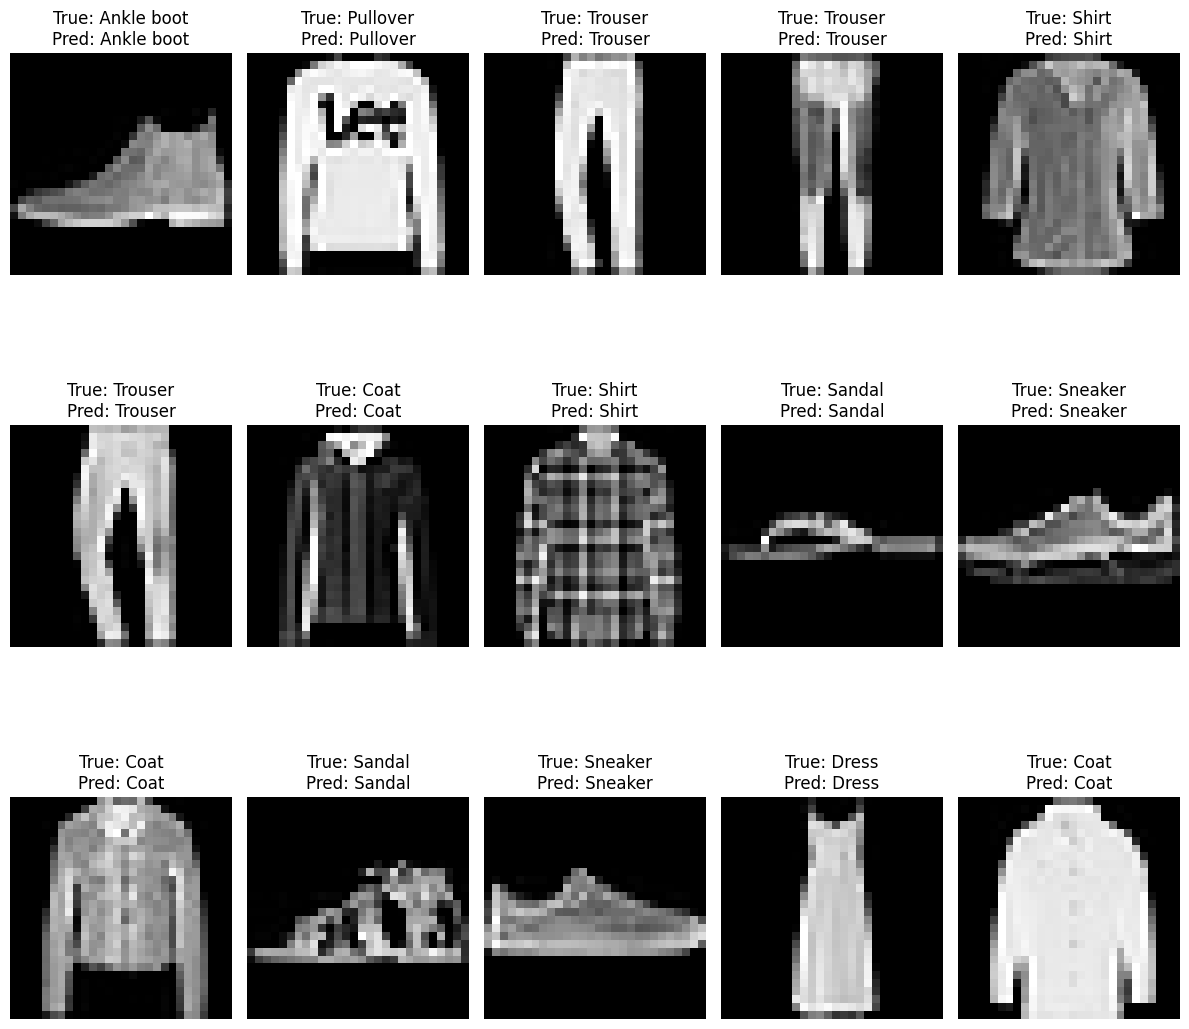

In [15]:
def visualize_predictions(model, data_loader, class_names):
    model.eval()
    with torch.no_grad():
        for x, y in data_loader:
            logits = model(x)
            predictions = torch.argmax(logits, dim=1)
            break

    x = x.numpy()
    y = y.numpy()
    predictions = predictions.numpy()

    fig, axes = plt.subplots(3, 5, figsize=(12, 12))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(x[i][0], cmap='gray')
        ax.set_title(f"True: {class_names[y[i]]}\nPred: {class_names[predictions[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
visualize_predictions(model, test_loader, class_names)
